# Setup and Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Loading the Dataset
Loading the fixed games dataset. The original CSV had a header error where a comma was missing between Discount and DLC count, which was manually corrected and saved as games_fixed.csv.

In [2]:
df = pd.read_csv('data/raw/games_fixed.csv')

print(f"Dataset shape: {df.shape}")
print(f"Total records: {df.shape[0]}")
print(f"Total features: {df.shape[1]}")
df.head()

Dataset shape: (111452, 40)
Total records: 111452
Total features: 40


,AppID,Name,Release date,Estimated owners,Peak CCU,Required age,Price,Discount,DLC count,About the game,Supported languages,Full audio languages,Reviews,Header image,Website,Support url,Support email,Windows,Mac,Linux,Metacritic score,Metacritic url,User score,Positive,Negative,Score rank,Achievements,Recommendations,Notes,Average playtime forever,Average playtime two weeks,Median playtime forever,Median playtime two weeks,Developers,Publishers,Categories,Genres,Tags,Screenshots,Movies
0,20200,Galactic Bowling,"Oct 21, 2008",0 - 20000,0,0,19.99,0,0,Galactic Bowling is an exaggerated and stylize...,['English'],[],NaN,https://cdn.akamai.steamstatic.com/steam/apps/...,http://www.galacticbowling.net,NaN,NaN,True,False,False,0,NaN,0,6,11,NaN,30,0,NaN,0,0,0,0,Perpetual FX Creative,Perpetual FX Creative,"Single-player,Multi-player,Steam Achievements,...","Casual,Indie,Sports","Indie,Casual,Sports,Bowling",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
1,655370,Train Bandit,"Oct 12, 2017",0 - 20000,0,0,0.99,0,0,THE LAW!! Looks to be a showdown atop a train....,"['English', 'French', 'Italian', 'German', 'Sp...",[],NaN,https://cdn.akamai.steamstatic.com/steam/apps/...,http://trainbandit.com,NaN,support@rustymoyher.com,True,True,False,0,NaN,0,53,5,NaN,12,0,NaN,0,0,0,0,Rusty Moyher,Wild Rooster,"Single-player,Steam Achievements,Full controll...","Action,Indie","Indie,Action,Pixel Graphics,2D,Retro,Arcade,Sc...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
2,1732930,Jolt Project,"Nov 17, 2021",0 - 20000,0,0,4.99,0,0,Jolt Project: The army now has a new robotics ...,"['English', 'Portuguese - Brazil']",[],NaN,https://cdn.akamai.steamstatic.com/steam/apps/...,NaN,NaN,ramoncampiaof31@gmail.com,True,False,False,0,NaN,0,0,0,NaN,0,0,NaN,0,0,0,0,Campião Games,Campião Games,Single-player,"Action,Adventure,Indie,Strategy",NaN,https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
3,1355720,Henosis™,"Jul 23, 2020",0 - 20000,0,0,5.99,0,0,HENOSIS™ is a mysterious 2D Platform Puzzler w...,"['English', 'French', 'Italian', 'German', 'Sp...",[],NaN,https://cdn.akamai.steamstatic.com/steam/apps/...,https://henosisgame.com/,https://henosisgame.com/,info@henosisgame.com,True,True,True,0,NaN,0,3,0,NaN,0,0,NaN,0,0,0,0,Odd Critter Games,Odd Critter Games,"Single-player,Full controller support","Adventure,Casual,Indie","2D Platformer,Atmospheric,Surreal,Mystery,Puzz...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
4,1139950,Two Weeks in Painland,"Feb 3, 2020",0 - 20000,0,0,0.00,0,0,ABOUT THE GAME Play as a hacker who has arrang...,"['English', 'Spanish - Spain']",[],NaN,https://cdn.akamai.steamstatic.com/steam/apps/...,https://www.unusual-games.com/home/,https://www.unusual-games.com/contact/,welistentoyou@unusual-games.com,True,True,False,0,NaN,0,50,8,NaN,17,0,This Game may contain content not appropriate ...,0,0,0,0,Unusual Games,Unusual Games,"Single-player,Steam Achievements","Adventure,Indie","Indie,Adventure,Nudity,Violent,Sexual Content,...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...


# Initial Data Exploration
Check basic information about the dataset including data types and missing values.

In [3]:
print("Dataset Info:")
print(df.info())
print("\n" + "="*50 + "\n")
print("Missing Values:")
missing = df.isnull().sum()
missing_pct = (missing / len(df)) * 100
missing_df = pd.DataFrame({'Missing Count': missing, 'Percentage': missing_pct})
print(missing_df[missing_df['Missing Count'] > 0].sort_values('Missing Count', ascending=False))

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111452 entries, 0 to 111451
Data columns (total 40 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   AppID                       111452 non-null  int64  
 1   Name                        111446 non-null  object 
 2   Release date                111452 non-null  object 
 3   Estimated owners            111452 non-null  object 
 4   Peak CCU                    111452 non-null  int64  
 5   Required age                111452 non-null  int64  
 6   Price                       111452 non-null  float64
 7   Discount                    111452 non-null  int64  
 8   DLC count                   111452 non-null  int64  
 9   About the game              104969 non-null  object 
 10  Supported languages         111452 non-null  object 
 11  Full audio languages        111452 non-null  object 
 12  Reviews                     10624 non-null   object 
 13  

# Removing Irrelevant or "Cheat" Features
Removing features that are:
- Blatantly irrelevant (e.g., URLs, images, identifiers)
- Would allow the model to "cheat" (e.g., Peak CCU, reviews, playtime stats measured after launch)

Our goal is to predict game popularity **before or at launch**, so post-launch metrics must be removed.

In [4]:
print("Original columns:")
print(df.columns.tolist())

# Features to drop
dropped_cols = [
    'AppID', 'Name', 'Peak CCU', 'Positive', 'Negative', 'Recommendations',
    'Score rank', 'User score', 'Metacritic score', 'Metacritic url',
    'Header image', 'Website', 'Support url', 'Support email',
    'Reviews', 'Notes', 'Screenshots', 'Movies',
    'Average playtime forever', 'Median playtime forever',
    'Average playtime two weeks', 'Median playtime two weeks'
]

df = df.drop(columns=dropped_cols)

print(f"\nDropped {len(dropped_cols)} features")
print(f"Remaining features: {df.shape[1]}")
print("\nRemaining columns:")
print(df.columns.tolist())

Original columns:
['AppID', 'Name', 'Release date', 'Estimated owners', 'Peak CCU', 'Required age', 'Price', 'Discount', 'DLC count', 'About the game', 'Supported languages', 'Full audio languages', 'Reviews', 'Header image', 'Website', 'Support url', 'Support email', 'Windows', 'Mac', 'Linux', 'Metacritic score', 'Metacritic url', 'User score', 'Positive', 'Negative', 'Score rank', 'Achievements', 'Recommendations', 'Notes', 'Average playtime forever', 'Average playtime two weeks', 'Median playtime forever', 'Median playtime two weeks', 'Developers', 'Publishers', 'Categories', 'Genres', 'Tags', 'Screenshots', 'Movies']

Dropped 22 features
Remaining features: 18

Remaining columns:
['Release date', 'Estimated owners', 'Required age', 'Price', 'Discount', 'DLC count', 'About the game', 'Supported languages', 'Full audio languages', 'Windows', 'Mac', 'Linux', 'Achievements', 'Developers', 'Publishers', 'Categories', 'Genres', 'Tags']


# Preserving Text Features for NLP
Identify and preserve the "About the game" text field for future NLP processing. This field should NOT be encoded or transformed.

In [5]:
# Preserve the text description field for NLP
text_feature = 'About the game'

if text_feature in df.columns:
    print(f"Found text feature for NLP: {text_feature}")
    
    # Store text data separately (as raw text)
    text_data = df[[text_feature]].copy()
    
    print(f"\nPreserved '{text_feature}' for NLP")
    print(f"Sample of preserved text:")
    print(df[text_feature].iloc[0][:200] + "..." if len(str(df[text_feature].iloc[0])) > 200 else df[text_feature].iloc[0])
else:
    print(f"Warning: '{text_feature}' column not found in dataset")
    text_data = None

Found text feature for NLP: About the game

Preserved 'About the game' for NLP
Sample of preserved text:
Galactic Bowling is an exaggerated and stylized bowling game with an intergalactic twist. Players will engage in fast-paced single and multi-player competition while being submerged in a unique new un...


# Target Variable Analysis and Transformation
Analyzing 'Estimated owners' and creating a categorical target variable 'popularity_class' with three levels:
- **Low**: ≤ 50,000 owners
- **Medium**: 50,001 - 500,000 owners
- **High**: > 500,000 owners

In [6]:
print("Unique values in 'Estimated owners':")
print(df['Estimated owners'].value_counts().sort_index())

# Check for and remove '0 - 0' range (noisy data)
print(f"\nRows with '0 - 0' range: {(df['Estimated owners'] == '0 - 0').sum()}")
df = df[df['Estimated owners'] != '0 - 0'].copy()
print(f"Rows after removal: {len(df)}")

Unique values in 'Estimated owners':
Estimated owners
0 - 0                    22091
0 - 20000                70206
100000 - 200000           2664
1000000 - 2000000          525
10000000 - 20000000         38
100000000 - 200000000        1
20000 - 50000             8277
200000 - 500000           2206
2000000 - 5000000          336
20000000 - 50000000         21
50000 - 100000            4068
500000 - 1000000           921
5000000 - 10000000          93
50000000 - 100000000         5
Name: count, dtype: int64

Rows with '0 - 0' range: 22091
Rows after removal: 89361


In [7]:
def categorize_popularity(owners_range):
    """
    Categorize game popularity based on estimated owners range.
    Low: <= 50,000
    Medium: 50,001 - 500,000
    High: > 500,000
    """
    if pd.isna(owners_range):
        return None
    
    # Remove commas and parse the range
    owners_range = owners_range.replace(',', '')
    low, high = map(int, owners_range.split(' - '))
    
    if high <= 50000:
        return 'Low'
    elif high <= 500000:
        return 'Medium'
    else:
        return 'High'

# Apply categorization
df['popularity_class'] = df['Estimated owners'].apply(categorize_popularity)

# Check distribution
print("Popularity class distribution:")
print(df['popularity_class'].value_counts())
print("\nPercentage distribution:")
print(df['popularity_class'].value_counts(normalize=True) * 100)

Popularity class distribution:
popularity_class
Low       78483
Medium     8938
High       1940
Name: count, dtype: int64

Percentage distribution:
popularity_class
Low       87.826904
Medium    10.002126
High       2.170969
Name: proportion, dtype: float64

popularity_class
Low       78483
Medium     8938
High       1940
Name: count, dtype: int64

Percentage distribution:
popularity_class
Low       87.826904
Medium    10.002126
High       2.170969
Name: proportion, dtype: float64


In [8]:
# Remove the original 'Estimated owners' column
df = df.drop(columns=['Estimated owners'])

# Move target variable to the end
target = 'popularity_class'
cols = [c for c in df.columns if c != target] + [target]
df = df[cols]

print("Dataset shape after target transformation:")
print(df.shape)
df.head()

Dataset shape after target transformation:
(89361, 18)


,Release date,Required age,Price,Discount,DLC count,About the game,Supported languages,Full audio languages,Windows,Mac,Linux,Achievements,Developers,Publishers,Categories,Genres,Tags,popularity_class
0,"Oct 21, 2008",0,19.99,0,0,Galactic Bowling is an exaggerated and stylize...,['English'],[],True,False,False,30,Perpetual FX Creative,Perpetual FX Creative,"Single-player,Multi-player,Steam Achievements,...","Casual,Indie,Sports","Indie,Casual,Sports,Bowling",Low
1,"Oct 12, 2017",0,0.99,0,0,THE LAW!! Looks to be a showdown atop a train....,"['English', 'French', 'Italian', 'German', 'Sp...",[],True,True,False,12,Rusty Moyher,Wild Rooster,"Single-player,Steam Achievements,Full controll...","Action,Indie","Indie,Action,Pixel Graphics,2D,Retro,Arcade,Sc...",Low
2,"Nov 17, 2021",0,4.99,0,0,Jolt Project: The army now has a new robotics ...,"['English', 'Portuguese - Brazil']",[],True,False,False,0,Campião Games,Campião Games,Single-player,"Action,Adventure,Indie,Strategy",NaN,Low
3,"Jul 23, 2020",0,5.99,0,0,HENOSIS™ is a mysterious 2D Platform Puzzler w...,"['English', 'French', 'Italian', 'German', 'Sp...",[],True,True,True,0,Odd Critter Games,Odd Critter Games,"Single-player,Full controller support","Adventure,Casual,Indie","2D Platformer,Atmospheric,Surreal,Mystery,Puzz...",Low
4,"Feb 3, 2020",0,0.00,0,0,ABOUT THE GAME Play as a hacker who has arrang...,"['English', 'Spanish - Spain']",[],True,True,False,17,Unusual Games,Unusual Games,"Single-player,Steam Achievements","Adventure,Indie","Indie,Adventure,Nudity,Violent,Sexual Content,...",Low


# Handling Missing Values
Identify features with missing values and determine appropriate imputation strategies.

In [9]:
# Detailed missing value analysis
missing_analysis = pd.DataFrame({
    'Feature': df.columns,
    'Missing_Count': df.isnull().sum(),
    'Missing_Percentage': (df.isnull().sum() / len(df)) * 100,
    'Data_Type': df.dtypes
})

missing_analysis = missing_analysis[missing_analysis['Missing_Count'] > 0].sort_values('Missing_Count', ascending=False)
print("Features with missing values:")
print(missing_analysis)

Features with missing values:
                       Feature  Missing_Count  Missing_Percentage Data_Type
Tags                      Tags          15332           17.157373    object
Categories          Categories           1161            1.299224    object
Publishers          Publishers            344            0.384955    object
About the game  About the game            106            0.118620    object
Genres                  Genres             77            0.086167    object
Developers          Developers              5            0.005595    object


In [10]:
# Strategy for handling missing values:
# 1. Numeric features: Impute with median (robust to outliers)
# 2. Categorical features: Impute with mode or 'Unknown'
# 3. Features with >50% missing: Consider dropping

# Separate numeric and categorical columns (excluding target)
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

# Remove target from categorical
if 'popularity_class' in categorical_cols:
    categorical_cols.remove('popularity_class')

# Remove text feature from categorical (preserve for NLP)
if text_feature in categorical_cols:
    categorical_cols.remove(text_feature)
    print(f"\nExcluded '{text_feature}' from categorical processing")

print(f"Numeric columns: {len(numeric_cols)}")
print(numeric_cols)
print(f"\nCategorical columns: {len(categorical_cols)}")
print(categorical_cols)

# Impute numeric columns with median
if numeric_cols:
    numeric_imputer = SimpleImputer(strategy='median')
    df[numeric_cols] = numeric_imputer.fit_transform(df[numeric_cols])

# Impute categorical columns with most frequent value
if categorical_cols:
    categorical_imputer = SimpleImputer(strategy='most_frequent')
    df[categorical_cols] = categorical_imputer.fit_transform(df[categorical_cols])

print("\nMissing values after imputation:")
print(df.isnull().sum().sum())


Excluded 'About the game' from categorical processing
Numeric columns: 5
['Required age', 'Price', 'Discount', 'DLC count', 'Achievements']

Categorical columns: 8
['Release date', 'Supported languages', 'Full audio languages', 'Developers', 'Publishers', 'Categories', 'Genres', 'Tags']

Numeric columns: 5
['Required age', 'Price', 'Discount', 'DLC count', 'Achievements']

Categorical columns: 8
['Release date', 'Supported languages', 'Full audio languages', 'Developers', 'Publishers', 'Categories', 'Genres', 'Tags']

Missing values after imputation:
106

Missing values after imputation:
106


# Handling Duplicates
Check for and remove duplicate records.

In [11]:
print(f"Total records before duplicate removal: {len(df)}")
print(f"Duplicate records: {df.duplicated().sum()}")

# Remove duplicates
df = df.drop_duplicates()

print(f"Total records after duplicate removal: {len(df)}")

Total records before duplicate removal: 89361
Duplicate records: 59
Duplicate records: 59
Total records after duplicate removal: 89302
Total records after duplicate removal: 89302


# Exploratory Data Analysis - Numerical Features
Analyze the distribution of numerical features and identify potential outliers.

In [12]:
# Statistical summary of numerical features
print("Numerical Features Summary:")
print(df[numeric_cols].describe())

Numerical Features Summary:
       Required age         Price      Discount     DLC count  Achievements
count  89302.000000  89302.000000  89302.000000  89302.000000  89302.000000
mean       0.297698      8.138997      0.579349      0.508981     20.302434
std        2.199236     12.594893      3.905602     12.997908    167.288883
min        0.000000      0.000000      0.000000      0.000000      0.000000
25%        0.000000      1.990000      0.000000      0.000000      0.000000
50%        0.000000      4.990000      0.000000      0.000000      4.000000
75%        0.000000      9.990000      0.000000      0.000000     20.000000
max       21.000000    999.980000     92.000000   2366.000000   9821.000000


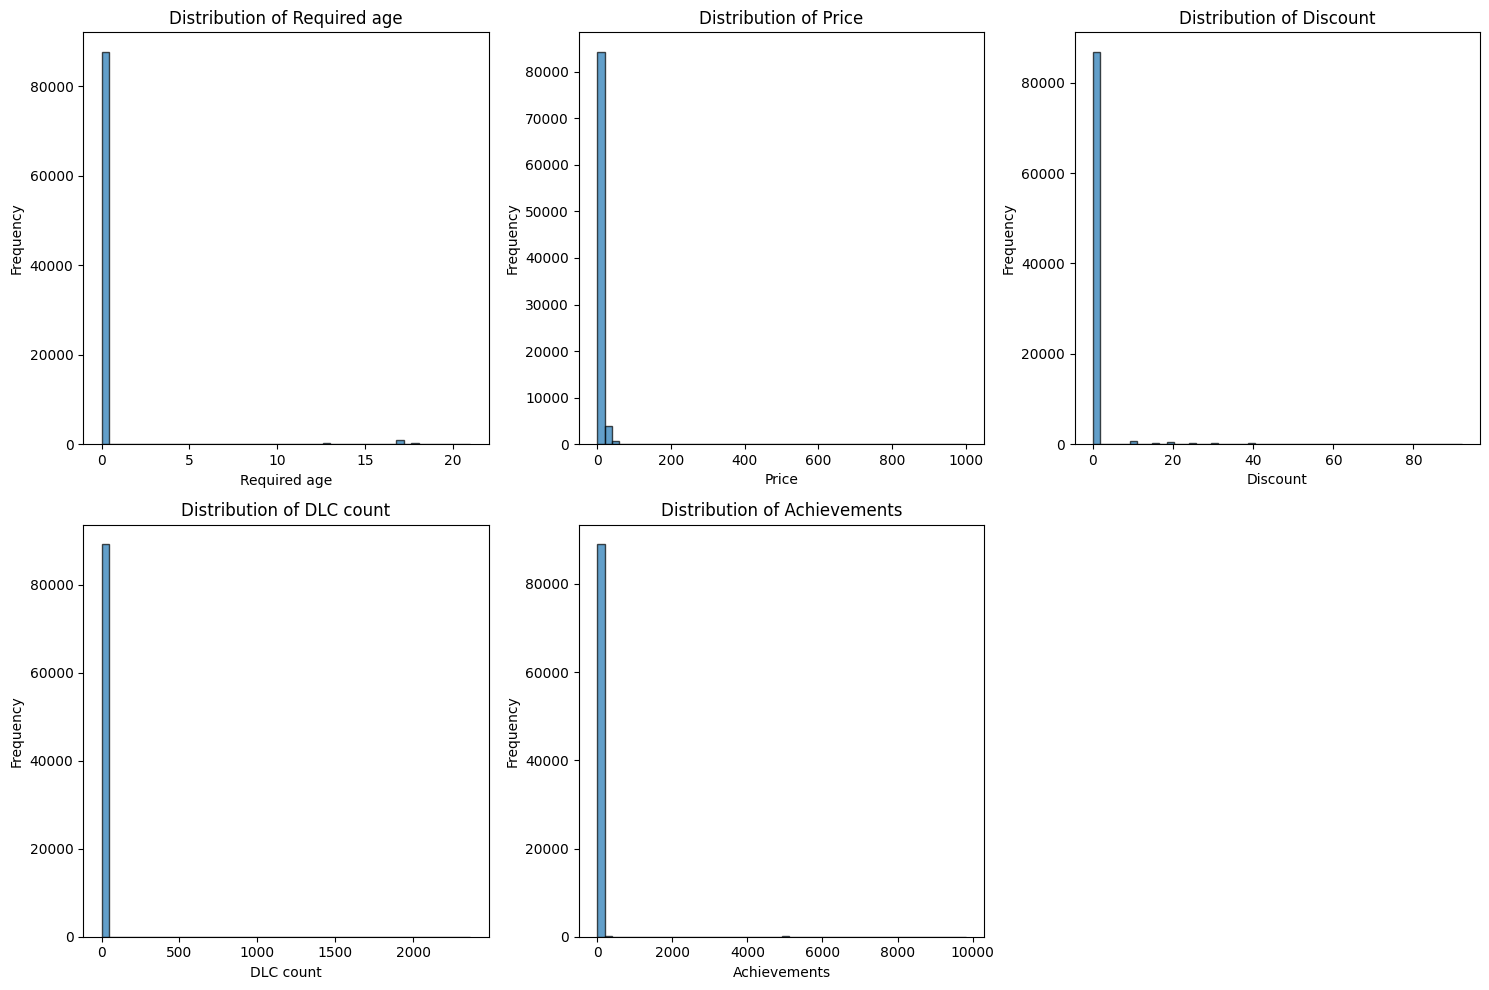

In [13]:
# Visualize distributions of key numerical features
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

# Select key numerical features to visualize
key_numeric_features = numeric_cols[:6] if len(numeric_cols) >= 6 else numeric_cols

for idx, col in enumerate(key_numeric_features):
    if idx < len(axes):
        axes[idx].hist(df[col].dropna(), bins=50, edgecolor='black', alpha=0.7)
        axes[idx].set_title(f'Distribution of {col}')
        axes[idx].set_xlabel(col)
        axes[idx].set_ylabel('Frequency')

# Hide extra subplots if we have fewer than 6 features
for idx in range(len(key_numeric_features), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

# Handling Outliers
Detect and handle outliers using the IQR (Interquartile Range) method.

In [14]:
def detect_outliers_iqr(data, column):
    """
    Detect outliers using IQR method.
    Returns indices of outliers.
    """
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers.index, lower_bound, upper_bound

# Analyze outliers for each numeric column
outlier_summary = []

for col in numeric_cols:
    outlier_indices, lower, upper = detect_outliers_iqr(df, col)
    outlier_count = len(outlier_indices)
    outlier_pct = (outlier_count / len(df)) * 100
    
    outlier_summary.append({
        'Feature': col,
        'Outlier_Count': outlier_count,
        'Outlier_Percentage': outlier_pct,
        'Lower_Bound': lower,
        'Upper_Bound': upper
    })

outlier_df = pd.DataFrame(outlier_summary).sort_values('Outlier_Count', ascending=False)
print("Outlier Analysis:")
print(outlier_df)

Outlier Analysis:
        Feature  Outlier_Count  Outlier_Percentage  Lower_Bound  Upper_Bound
3     DLC count          12452           13.943697         0.00         0.00
4  Achievements           5151            5.768068       -30.00        50.00
1         Price           4978            5.574343       -10.01        21.99
2      Discount           2491            2.789411         0.00         0.00
0  Required age           1641            1.837585         0.00         0.00


In [15]:
# Option 1: Cap outliers at bounds (Winsorization)
# Option 2: Remove extreme outliers (only if percentage is very small)

# For this project, we'll cap outliers to preserve data
print(f"Dataset size before outlier handling: {len(df)}")

for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Cap outliers
    df[col] = df[col].clip(lower=lower_bound, upper=upper_bound)

print(f"Dataset size after outlier handling: {len(df)}")
print("Outliers have been capped to IQR bounds")

Dataset size before outlier handling: 89302
Dataset size after outlier handling: 89302
Outliers have been capped to IQR bounds


# Feature Engineering - Categorical Features
Analyze and encode categorical features. Check for high cardinality features that may need special handling.

In [16]:
# Analyze categorical features
categorical_info = []

for col in categorical_cols:
    unique_count = df[col].nunique()
    top_value = df[col].mode()[0] if len(df[col].mode()) > 0 else None
    top_value_count = (df[col] == top_value).sum() if top_value else 0
    top_value_pct = (top_value_count / len(df)) * 100
    
    categorical_info.append({
        'Feature': col,
        'Unique_Values': unique_count,
        'Top_Value': top_value,
        'Top_Value_Percentage': top_value_pct
    })

categorical_info_df = pd.DataFrame(categorical_info).sort_values('Unique_Values', ascending=False)
print("Categorical Features Analysis:")
print(categorical_info_df)

Categorical Features Analysis:
                Feature  Unique_Values        Top_Value  Top_Value_Percentage
7                  Tags          67070     Indie,Casual             17.475532
3            Developers          55136  EroticGamesClub              0.217240
4            Publishers          48282   Big Fish Games              0.951826
1   Supported languages          13343      ['English']             51.655058
5            Categories           6464    Single-player             25.371212
0          Release date           4907     Oct 24, 2024              0.133256
2  Full audio languages           2557               []             57.011041
6                Genres           2325     Casual,Indie              6.242861


In [17]:
# For high cardinality features (like Categories, Genres, Tags), 
# we'll use one-hot encoding or handle them separately
# For now, let's check which features have manageable cardinality

print("\nFeatures by cardinality:")
print("Low cardinality (<10):", [col for col in categorical_cols if df[col].nunique() < 10])
print("Medium cardinality (10-50):", [col for col in categorical_cols if 10 <= df[col].nunique() < 50])
print("High cardinality (>=50):", [col for col in categorical_cols if df[col].nunique() >= 50])


Features by cardinality:
Low cardinality (<10): []
Medium cardinality (10-50): []
High cardinality (>=50): ['Release date', 'Supported languages', 'Full audio languages', 'Developers', 'Publishers', 'Categories', 'Genres', 'Tags']


# Encoding Categorical Features
For categorical features:
- Low cardinality: Use Label Encoding or One-Hot Encoding
- High cardinality (like Categories, Genres, Tags): These may contain multiple values separated by commas. We'll handle them using multi-label encoding or create binary features for top categories.

In [18]:
# Identify features that might contain multiple values (comma-separated)
multi_value_features = []

for col in categorical_cols:
    sample_values = df[col].dropna().head(10)
    if sample_values.astype(str).str.contains(',').any():
        multi_value_features.append(col)
        print(f"\n{col} (multi-value feature):")
        print(sample_values.head(3))

print(f"\nMulti-value features: {multi_value_features}")

# Separate single-value and multi-value categorical features
single_value_categorical = [col for col in categorical_cols if col not in multi_value_features]
print(f"\nSingle-value categorical features: {single_value_categorical}")


Release date (multi-value feature):
0    Oct 21, 2008
1    Oct 12, 2017
2    Nov 17, 2021
Name: Release date, dtype: object

Supported languages (multi-value feature):
0                                          ['English']
1    ['English', 'French', 'Italian', 'German', 'Sp...
2                   ['English', 'Portuguese - Brazil']
Name: Supported languages, dtype: object

Full audio languages (multi-value feature):
0    []
1    []
2    []
Name: Full audio languages, dtype: object

Publishers (multi-value feature):
0    Perpetual FX Creative
1             Wild Rooster
2            Campião Games
Name: Publishers, dtype: object

Categories (multi-value feature):
0    Single-player,Multi-player,Steam Achievements,...
1    Single-player,Steam Achievements,Full controll...
2                                        Single-player
Name: Categories, dtype: object

Genres (multi-value feature):
0                Casual,Indie,Sports
1                       Action,Indie
2    Action,Adventure,Indie,S

In [19]:
# For single-value categorical features with low cardinality, use Label Encoding
# This is suitable for features like 'Required age', 'Windows', 'Mac', 'Linux', etc.

label_encoders = {}

for col in single_value_categorical:
    if df[col].nunique() < 20:  # Only encode features with < 20 unique values
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))
        label_encoders[col] = le
        print(f"Label encoded: {col} ({len(le.classes_)} classes)")

print(f"\nTotal features label encoded: {len(label_encoders)}")


Total features label encoded: 0


In [20]:
# For multi-value features (Categories, Genres, Tags), create binary features for top N values
# This approach is commonly used for multi-label features

import re

def create_top_n_binary_features(df, column, top_n=20):
    """
    Create binary features for the top N most common values in a multi-value column.
    Uses re.escape to avoid regex errors when values contain special characters like '['.
    """
    # Get all values across all rows
    all_values = []
    for val in df[column].dropna():
        if isinstance(val, str):
            all_values.extend([v.strip() for v in val.split(',')])
    
    # Count occurrences
    from collections import Counter
    value_counts = Counter(all_values)
    top_values = [val for val, count in value_counts.most_common(top_n)]
    
    print(f"\nTop {len(top_values)} values in {column}:")
    for val, count in value_counts.most_common(top_n):
        print(f"  {val}: {count}")
    
    # Create binary features
    for value in top_values:
        # skip empty values
        if not value:
            continue
        # make a safe feature name by replacing non-alphanumeric chars with underscores
        safe_value = re.sub(r'[^0-9A-Za-z_]+', '_', value).strip('_')
        feature_name = f"{column}_{safe_value}"
        # Escape the value for literal matching to avoid regex compilation errors
        pattern = re.escape(value)
        df[feature_name] = df[column].astype(str).str.contains(pattern, case=False, na=False, regex=True).astype(int)
    
    return df, top_values

# Apply to multi-value features
for col in multi_value_features:
    print(f"\n{'='*60}")
    print(f"Processing multi-value feature: {col}")
    df, top_values = create_top_n_binary_features(df, col, top_n=15)
    print(f"Created {len(top_values)} binary features for {col}")


Processing multi-value feature: Release date

Top 15 values in Release date:
  2024: 12131
  2021: 10557
  2022: 10308
  2023: 9867
  2020: 9549
  2018: 8126
  2019: 7796
  2017: 6309
  2016: 4394
  2025: 3753
  2015: 2668
  2014: 1620
  2013: 463
  Nov 1: 387
  Sep 30: 381
Created 15 binary features for Release date

Processing multi-value feature: Supported languages

Top 15 values in Supported languages:
  ['English']: 46129
  ['English': 37103
  'German': 19446
  'French': 19292
  'Spanish - Spain': 16364
  'Simplified Chinese': 14225
  'Italian': 13573
  'Russian': 13368
  'Japanese': 12817
  'Portuguese - Brazil': 8746
  'Korean': 8688
  'Polish': 7426
  'Traditional Chinese': 6960
  'Russian']: 5871
  'Simplified Chinese']: 5199
Created 15 binary features for Release date

Processing multi-value feature: Supported languages

Top 15 values in Supported languages:
  ['English']: 46129
  ['English': 37103
  'German': 19446
  'French': 19292
  'Spanish - Spain': 16364
  'Simplified

C:\Users\Awsom\AppData\Local\Temp\ipykernel_33960\3738306216.py:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[feature_name] = df[column].astype(str).str.contains(pattern, case=False, na=False, regex=True).astype(int)
C:\Users\Awsom\AppData\Local\Temp\ipykernel_33960\3738306216.py:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[feature_name] = df[column].astype(str).str.contains(pattern, case=False, na=False, regex=True).astype(int)
C:\Users\Awsom\AppData\Local\Temp\ipykernel_33960\3738306216.py:36: PerformanceWarning

Created 15 binary features for Tags


C:\Users\Awsom\AppData\Local\Temp\ipykernel_33960\3738306216.py:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[feature_name] = df[column].astype(str).str.contains(pattern, case=False, na=False, regex=True).astype(int)
C:\Users\Awsom\AppData\Local\Temp\ipykernel_33960\3738306216.py:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[feature_name] = df[column].astype(str).str.contains(pattern, case=False, na=False, regex=True).astype(int)


In [21]:
# Drop the original multi-value categorical columns
df = df.drop(columns=multi_value_features)
print(f"\nDropped original multi-value columns: {multi_value_features}")
print(f"Current dataset shape: {df.shape}")


Dropped original multi-value columns: ['Release date', 'Supported languages', 'Full audio languages', 'Publishers', 'Categories', 'Genres', 'Tags']
Current dataset shape: (89302, 110)


# Feature Scaling
Normalize numerical features using StandardScaler to ensure all features are on the same scale.

In [22]:
# Get all numeric columns (excluding target)
numeric_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

print(f"Numeric features to scale: {len(numeric_features)}")
print(numeric_features[:10])  # Show first 10

# Apply StandardScaler
scaler = StandardScaler()
df[numeric_features] = scaler.fit_transform(df[numeric_features])

print("\nFeatures scaled using StandardScaler")
print("\nSample of scaled data:")
print(df[numeric_features].head())

Numeric features to scale: 104
['Required age', 'Price', 'Discount', 'DLC count', 'Achievements', 'Release date_2024', 'Release date_2021', 'Release date_2022', 'Release date_2023', 'Release date_2020']

Features scaled using StandardScaler

Sample of scaled data:
   Required age     Price  Discount  DLC count  Achievements  \
0           0.0  2.007898       0.0        0.0      1.172517   
1           0.0 -0.963858       0.0        0.0      0.016725   
2           0.0 -0.338225       0.0        0.0     -0.753803   
3           0.0 -0.181817       0.0        0.0     -0.753803   
4           0.0 -1.118702       0.0        0.0      0.337779   

   Release date_2024  Release date_2021  Release date_2022  Release date_2023  \
0           -0.39648          -0.366464          -0.361334          -0.352441   
1           -0.39648          -0.366464          -0.361334          -0.352441   
2           -0.39648           2.728778          -0.361334          -0.352441   
3           -0.39648      

# Final Dataset Overview
Review the preprocessed dataset before saving.

In [23]:
print("="*60)
print("FINAL PREPROCESSED DATASET SUMMARY")
print("="*60)
print(f"\nDataset shape: {df.shape}")
print(f"Total samples: {df.shape[0]}")
print(f"Total features: {df.shape[1]}")

print("\n" + "-"*60)
print("Feature Types:")
print("-"*60)
print(f"Numeric features: {len(df.select_dtypes(include=['int64', 'float64']).columns)}")
print(f"Categorical features: {len(df.select_dtypes(include=['object']).columns)}")

print("\n" + "-"*60)
print("Missing Values:")
print("-"*60)
print(f"Total missing values: {df.isnull().sum().sum()}")

print("\n" + "-"*60)
print("Target Variable Distribution:")
print("-"*60)
print(df['popularity_class'].value_counts())
print("\nPercentage distribution:")
print(df['popularity_class'].value_counts(normalize=True) * 100)

print("\n" + "-"*60)
print("Sample of preprocessed data:")
print("-"*60)
print(df.head(10))

FINAL PREPROCESSED DATASET SUMMARY

Dataset shape: (89302, 110)
Total samples: 89302
Total features: 110

------------------------------------------------------------
Feature Types:
------------------------------------------------------------
Numeric features: 104
Categorical features: 3

------------------------------------------------------------
Missing Values:
------------------------------------------------------------
Total missing values: 106

------------------------------------------------------------
Target Variable Distribution:
------------------------------------------------------------
popularity_class
Low       78429
Medium     8934
High       1939
Name: count, dtype: int64

Percentage distribution:
popularity_class
Low       87.824461
Medium    10.004255
High       2.171284
Name: proportion, dtype: float64

------------------------------------------------------------
Sample of preprocessed data:
------------------------------------------------------------
   Required ag

In [24]:
df.head()

,Required age,Price,Discount,DLC count,About the game,Windows,Mac,Linux,Achievements,Developers,popularity_class,Release date_2024,Release date_2021,Release date_2022,Release date_2023,Release date_2020,Release date_2018,Release date_2019,Release date_2017,Release date_2016,Release date_2025,Release date_2015,Release date_2014,Release date_2013,Release date_Nov_1,Release date_Sep_30,Supported languages_English,Supported languages_German,Supported languages_French,Supported languages_Spanish_Spain,Supported languages_Simplified_Chinese,Supported languages_Italian,Supported languages_Russian,Supported languages_Japanese,Supported languages_Portuguese_Brazil,Supported languages_Korean,Supported languages_Polish,Supported languages_Traditional_Chinese,Full audio languages_,Full audio languages_English,Full audio languages_German,Full audio languages_French,Full audio languages_Spanish_Spain,Full audio languages_Italian,Full audio languages_Russian,Full audio languages_Simplified_Chinese,Full audio languages_Japanese,Full audio languages_Traditional_Chinese,Full audio languages_Portuguese_Brazil,Full audio languages_Polish,Publishers_Big_Fish_Games,Publishers_Inc,Publishers_LLC,Publishers_Ltd,Publishers_8floor,Publishers_SEGA,Publishers_LTD,Publishers_EroticGamesClub,Publishers_Square_Enix,Publishers_Strategy_First,Publishers_HH_Games,Publishers_Choice_of_Games,Publishers_Sekai_Project,Publishers_Electronic_Arts,Publishers_Atomic_Fabrik,Categories_Single_player,Categories_Steam_Achievements,Categories_Steam_Cloud,Categories_Full_controller_support,Categories_Multi_player,Categories_Family_Sharing,Categories_Partial_Controller_Support,Categories_Steam_Trading_Cards,Categories_PvP,Categories_Co_op,Categories_Steam_Leaderboards,Categories_Online_PvP,Categories_Remote_Play_Together,Categories_Shared_Split_Screen,Categories_Online_Co_op,Genres_Indie,Genres_Casual,Genres_Action,Genres_Adventure,Genres_Simulation,Genres_Strategy,Genres_RPG,Genres_Early_Access,Genres_Sports,Genres_Free_to_Play,Genres_Racing,Genres_Massively_Multiplayer,Genres_Utilities,Genres_Violent,Genres_Design_Illustration,Tags_Indie,Tags_Casual,Tags_Singleplayer,Tags_Action,Tags_Adventure,Tags_2D,Tags_Simulation,Tags_Strategy,Tags_RPG,Tags_Atmospheric,Tags_3D,Tags_Puzzle,Tags_Pixel_Graphics,Tags_Early_Access,Tags_Colorful
0,0.0,2.007898,0.0,0.0,Galactic Bowling is an exaggerated and stylize...,True,False,False,1.172517,Perpetual FX Creative,Low,-0.39648,-0.366464,-0.361334,-0.352441,-0.346348,-0.316734,-0.309642,-0.275950,-0.227731,-0.209451,-0.175827,-0.136225,-0.072349,-0.193157,-0.065458,0.270053,-0.556198,-0.547046,-0.520268,-0.294499,-0.432350,-0.268355,-0.514250,-0.374245,-0.387698,-0.319296,-0.376284,0.868358,-0.78512,-0.213897,-0.205221,-0.204122,-0.162991,-0.160108,-0.2501,-0.233495,-0.14261,-0.162665,-0.136267,-0.09832,-0.137372,-0.150153,-0.119582,-0.058829,-0.050146,-0.119582,-0.046053,-0.045562,-0.045562,-0.044816,-0.043285,-0.042762,-0.042631,-0.042366,0.205191,1.063010,-0.572963,-0.511969,2.150245,-0.43703,2.628256,-0.354926,-0.351658,-0.319359,-0.300032,-0.286017,-0.281247,-0.288598,-0.234107,0.647059,1.168757,-0.832693,-0.800291,-0.504468,-0.485989,-0.467039,-0.386742,4.586235,-0.206904,-0.196532,-0.146207,-0.099072,-0.076753,-0.076383,0.69541,0.947896,-0.919222,-0.806877,-0.774296,-0.578773,-0.463941,-0.474388,-0.457673,-0.424993,-0.446967,-0.439190,-0.380153,-0.377466,-0.376866
1,0.0,-0.963858,0.0,0.0,THE LAW!! Looks to be a showdown atop a train....,True,True,False,0.016725,Rusty Moyher,Low,-0.39648,-0.366464,-0.361334,-0.352441,-0.346348,-0.316734,-0.309642,3.623851,-0.227731,-0.209451,-0.175827,-0.136225,-0.072349,-0.193157,-0.065458,0.270053,1.797922,1.827999,1.922088,-0.294499,2.312939,-0.268355,1.944579,2.672045,-0.387698,-0.319296,2.657566,0.868358,-0.78512,-0.213897,-0.205221,-0.204122,-0.162991,-0.160108,-0.2501,-0.233495,-0.14261,-0.162665,-0.136267,-0.09832,-0.137372,-0.150153,-0.119582,-0.058829,-0.050146,-0.119582,-0.046053,-0.045562,-0

# Saving Preprocessed Dataset
Save the preprocessed dataset to CSV for use in machine learning models.

In [ ]:
# Add text feature back to the dataset (as raw text for NLP)
if text_data is not None:
    df = pd.concat([df, text_data], axis=1)
    print(f"Added '{text_feature}' back to dataset for NLP")

output_path = 'data/processed/games_preprocessed.csv'

df.to_csv(output_path, index=False)

print(f"\nPreprocessed dataset saved to: {output_path}")
print(f"File size: {df.shape[0]} rows × {df.shape[1]} columns")
print("\nPreprocessing complete! ✓")

# Summary of Preprocessing Steps

This notebook completed the following preprocessing steps:

1. **Data Loading**: Loaded the fixed games dataset (games_fixed.csv)

2. **Feature Selection**: 
   - Removed irrelevant features (URLs, images, identifiers)
   - Removed "cheat" features (post-launch metrics like Peak CCU, reviews, playtime)
   - Preserved "About the game" text field as raw text for future NLP processing

3. **Target Variable Transformation**:
   - Removed rows with "0 - 0" estimated owners (noisy data)
   - Created categorical target variable `popularity_class` with 3 levels: Low, Medium, High
   - Removed original `Estimated owners` column

4. **Data Cleaning**:
   - Handled missing values using median imputation for numeric features
   - Handled missing values using mode imputation for categorical features
   - Removed duplicate records

5. **Outlier Detection and Handling**:
   - Detected outliers using IQR method
   - Capped outliers to preserve data (Winsorization)

6. **Feature Engineering**:
   - Identified single-value and multi-value categorical features
   - Applied Label Encoding to low-cardinality categorical features
   - Created binary features for top values in multi-value features (Categories, Genres, Tags)

7. **Feature Scaling**:
   - Applied StandardScaler to all numeric features for normalization

8. **Output**:
   - Added "About the game" text field back to the dataset (preserved as raw text for NLP)
   - Saved preprocessed dataset to `data/processed/games_preprocessed.csv`

The dataset is now ready for machine learning model training and NLP analysis!